In [1]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# QEC 101
## Lab 6 - Topological Codes

This lab builds on the stabilizer formalism introduced in [lab 2]() towards much more complex yet powerful QEC codes: the topological codes. [Recent announcements](https://research.google/blog/making-quantum-error-correction-work/) from Google about their new Willow chip have brought a specific topological code (the surface code) center stage, as it is the primary code being explored by Google today and a very promising candidate for useful QEC.

The toric code is one of the earliest topological QEC codes and a precursor to the surface code. It is a more complex code relative to the repetiton code and Steane code, but also elegant and worth the time to understand. This lab introduces you to the conceptual aspects of the toric code and enables you to code an implementation yourself. 

The list below outlines what you'll be doing in each section of this lab:

* **6.1** Learn about topological codes and why they are so promising.
* **6.2** Learn the toric code layout and its stabilizers
* **6.3** Learn the toric code logical operators
* **6.4** Learn how to code the toric code in CUDA-Q
* **6.5** Learn how to decode the toric code errors
* **6.6** Implement a minimum weight perfect matching decoder
* **6.7** Learn about the planar and surface codes

Lab 5 Learning Objectives:
* What are topological codes and why are they so promising. 
* Understand the basics of the toric code and how to construct it visually
* Understand how to intupret toric code errors
* Understand how to code the toric code in CUDA-Q
* Understand how minimum-weight perfect matching decoding works


Terminology and notation you'll use:

* topological code, toric code, surface code, threshold
* stabilizers, logical operators, syndromes
* minimum weight perfect matching

This lab was inspired by excellent work in [*Quantum Error Correction an Introductory Guide*](https://arxiv.org/pdf/1907.11157) and a blog entitled [*An Interactive Guide to the Surface Code*](https://arthurpesah.me/blog/2023-05-13-surface-code/#solution-of-the-exercise)

Execute the cell below to load all the necessary packages for this lab. 

In [2]:
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import sys

try:
    import networkx as nx

except ImportError:
    print("Tools not found, installing. Please restart your kernel after this is done.")
    !{sys.executable} -m pip install --upgrade networkx
    print("\nNew libraries have been installed. Please restart your kernel!")

import cudaq
cudaq.set_target('stim')

## 6.1 What is a topological code?

The previous lab discussed stabilizers, and how the stabilizer formalism can be a helpful tool for generating more complex QEC codes, particularly at scales where specifying the codewords is impractical.  The **toric code** is one of the most famous **topological** codes which combines the stabilizer formalism and principles of topology to produce a QEC code with a number of favorable properties.  

**Topology** is a branch of mathematics that studies objects abstractly and relates them to so called equivalence classes based on how they can or cannot be transformed into one another. The prototypical example given to introduce topology proposes that a doughnut and a coffee mug are in the same class (see image below), as they each have one hole while a shape like a sphere, would be in a different equivalence class.

<img src="../Images/toric/mug.jpg"  title="Landscape Image" width="500">

The coffee mug example, though certainly not rigorous and perhaps somewhat arbitrary, is an accessible glance into the sorts of distinctions topology can make to classify all sorts of geometries, even those that cannot be visualized.  Though the details of topology are well outside the scope of this lab, they provide the theoretical foundation of the surface code which takes advantage of the notion of equivalence classes to perform error correction on qubits arranged on a surface.

The key idea of the surface code is to define stabilizers as small repeating units that can be visually represented on a grid. Repeating such units results in a systematic way to increase the number of data qubits that encode one or more logical qubits, and increase the distance of the code. Defining the code on a grid pays dividends for leveraging topological principles to define errors and logical operations in such a way that lends itself to a nice visual interpretation.  Ideally, surface code errors are localized and can be visually inspected much like one can look at an image, assuming the pixels are large enough, and quickly identify which pixels are the wrong color.

Certain types of QPUs (such as superconducting) are well suited for the surface code as qubits are already arranged on surface with nearest neighbor connectivity.

The surface code also has a high **threshold**.  The threshold of a QEC code is the error rate required of physical qubits such that adding more physical qubits improves the logical error rate and does not make it worse.  A high threshold means that the surface code can tolerate physical qubits of lower relative quality than other codes. 


## 6.2 The Toric Code and its Stabilizers

The starting point for the toric code is a grid, the lines of which correspond to lines on the surface of a torus (doughnut shape). The horizontal grid lines (like the blue line below) wrap around the equator of the torus. The vertical lines (like the red line) wrap inside of the "doughnut hole" of the torus. In order for the grid to appropriately resemble the torus, the endpoints of any grid line connect.  Notice that the point A on the torus corresponds to both the left and right endpoint of the blue horizontal line.

<img src="../Images/toric/torus.png"  title="Landscape Image" width="1000">

<p><em>Image adapted from https://en.wikipedia.org/wiki/Torus#/media/File:Tesseract_torus.png</em></p>


Each edge (line connecting two vertices) of the grid corresponds to a data qubit depicted by grey squares. The toric code is a $[[2L^2, 2,  L]]$ code, encoding two logical qubits, where $L$ is the number of vertical/horizontal edges in each row/column.

<img src="../Images/toric/dataqubits.png"  title="Landscape Image" width="800">


### Stabilizers 

Stabilizers come in two varieties: plaquette and vertex. A plaquette stabilizer corresponds to the an ancilla qubit (black circle) which sits in the center of each face.  The stabilizer consists of four $X$ operators acting on the four adjacent (green edge) qubits. Similarly, each vertex stabilizers corresponds to an ancilla qubit placed at each grid vertex and consists of four $Z$ operators acting on the four adjacent (purple edge) qubits.

<img src="../Images/toric/toricstabilizers.png"  title="Landscape Image" width="1200">


### Confirming Stabilizers Commute

Remember from Lab 2 that all stabilizers must commute with one another. Consider the three possible cases to confirm that the commutation relationships hold.

1. *The stabilizers do not intersect*:  This is the trivial case as two stabilizers acting on completely different qubits will trivially commute.

2. *Two stabilizers of the same sort intersect*:  Considering the plaquette stabilizers only as the same logic holds for vertex stabilizers, notice that the only way for two different plaquette stabilizers to intersect is if they share one data qubit.  That is, two green squares share an edge. In the example below, the $X_2$ operations cancel out and the commutation relationship holds for the other operators acting on different qubits.

 <img src="../Images/toric/commute1.png"  title="Landscape Image" width="400">

3.  *A plaquette and vertex stabilizer intersect*: This is the most complex case. Notice, that this can only occur when a green square intersects a purple cross on two shared data qubits. When a $Z$ and an $X$ type operator act on the same qubit an anti-commutation relationship holds and a negative phase is added.  However, if this occurs for a pair of operators acting on a second qubit, the anti-commutation relationships cancel and the entire stabilizer commutes.

<img src="../Images/toric/commute2.png"  title="Landscape Image" width="300">


## 6.3 Logical Operators

In order to understand logical operators, it is necessary to consider the topology of the torus and specifically the sorts of loops that can be drawn on it. It turns out, that there are four sorts of loops that can occur on the torus, each as a distinct equivalence class. 

1. A trivial loop (yellow) is simply a closed loop on the surface of the torus.
2. A Vertical loop (red and green) is a loop through the center hole.
3. A horizontal loop (blue and orange) is a loop that goes around the equator of the torus.
4. A Vertical + Horizontal loop combines the two, looping around the equator with a twist through the center hole.


 <img src="../Images/toric/loops.png"  title="Landscape Image" width="600">

Each sort of loop also manifest within the toric code and correspond to either stabilizers or logical operators. 


First consider trivial loops. In the section above, it was noted that the product of two overlapping plaquette (or vertex) stabilizers commute because the operation performed on the overlapping qubit cancels out.  Another way to think about this, is the formation of a larger loop which is just another stabilizer!

 <img src="../Images/toric/trivialloops.png"  title="Landscape Image" width="600">


One could continue to add plaquette stabilizers and expand the loop, or work backwards and cancel out the previous stabilizers to recover $\ket{\psi}$. This means that any closed loop on the surface is a stabilizer and in the same equivalence class with the original state.

This is not true for a vertical or horizintal loop (pictured below).  There is no way to apply stabilizers to either state to recover $\ket{\psi}$ Therefore, such loops are in a different equivalence class. It turns out that a horizontal loop (if formed by consecutive $X$ operators) is $\bar{X}_1$ and a vertical loop is $\bar{X}_2$.   

 <img src="../Images/toric/logicalloops.png"  title="Landscape Image" width="600">

Just as all stabilizers correspond to the same equivalence class, there are many ways to produce vertical and horizontal loops. Such loops do not need to be "straight" and can follow a windy path as pictured below.

 <img src="../Images/toric/windy.png"  title="Landscape Image" width="400">


It is also possible for two distinct loops to close along the same axis corresponding to $\bar{X}_i$$\bar{X}_i$, that is, the application of the logical operator twice.

 <img src="../Images/toric/twodistinctloops.png"  title="Landscape Image" width="400">
 
Finally, if a vertical and horizontal loop close, the results is the same as both logical bitflip operators $\bar{X}_1$$\bar{X}_2$


 <img src="../Images/toric/twoloops.png"  title="Landscape Image" width="400">

All of this logic is identical for the $Z$-type vertex stabilizer. The only difference is that $\bar{Z}_1$ and $\bar{Z}_2$ correspond to vertical and horizontal loops formed by data qubits on parallel faces of the grid (purple lines). 


 <img src="../Images/toric/zcases.png"  title="Landscape Image" width="900">



 $\bar{Z}_1$  and $\bar{X}_1$ need to anticommute which is why a horizontal loop formed by green lines and vertical loops formed by purple lines operate on the same logical qubit. Anticommutation is presevered as a $Z$ and $X$ operator must both occur on an odd number of data qubits.


 <img src="../Images/toric/anticommute.png"  title="Landscape Image" width="400">



## 6.4  Implementing the toric code in CUDA-Q


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px;">
    <h3 style="color: #76b900; margin-top: 0;"> Exercise  1:</h3>
    <p style="font-size: 16px; color: #333;">
You will now code the toric code in CUDA-Q. It is important to note that there are many nuances that arise when coding the toric code that have not been considered in the conceptual discussions above.  For example, in the presence of errors, the order in which the stabilizer gates are applied in the encoding stage matters for the propagation of errors.  Such considerations will be ignored for simplicity but are important to note regardless. 

In the cells below, you will perform the encoding for the toric code. First, calculate the indices of the stabilizers and print them to ensure all are correct.  As the L=3 toric code is an [[18,2,3]] code, only 16 stabilizers are required to reinforce the constraints as all 9 vertex and plaquette stabilizers must produce a product of 1. However, it is OK to use all 18 stabilizers for clarity despite the redundancy as the extra two stabilizers do not add additional constraints.

In the cell below, write code that produces the indices for each plaquette (catch $Z$ errors) and vertex (catch $X$ errors) stabilizers.  Use the indexing below to match the solution key. Notice how there are 18 data and ancilla qubits. Note: Store the indicies in a single flattened list (one for each stabilizer type) so that they can be easily read into CUDA-Q kernels. 

Complete the additional tasks in the following cells.
    </p>
</div>


 <img src="../Images/toric/qubitindex.png"  title="Landscape Image" width="400">


Print the stabilizers and confirm your code works. Do they match what you would expect from the image above?

In [3]:
#TODO 
#Write code here to generate the indicices of each stabilizer.
L=3

stabilizers_z = []   # Plaquette stabilizers that flag Z errors
for row in range(L):
  for col in range(L):  
      stabilizers_z.append(L*row + col+L**2)      #left
      stabilizers_z.append(L*row + col )       #top
      stabilizers_z.append((L*row + (col+1)%L)+L**2)  #right
      stabilizers_z.append(L*((row + 1)%L) +col)     #bottom


stabilizers_x = []  # vertex stabilizers that flag X errors
for row in range(L):
  for col in range(L):  
      stabilizers_x.append( (L*row + (col -1 )%L))      #left
      stabilizers_x.append(L*((row-1)%L) + col + L**2)       #top
      stabilizers_x.append(L*row +col)  #right
      stabilizers_x.append(L*row +col + L**2 )     #bottom



print("plaq")
for x in range(L**2):
    print(stabilizers_z[4*x], stabilizers_z[4*x+1],stabilizers_z[4*x+2],stabilizers_z[4*x+3])

print("vertex")
for x in range(L**2):
    print(stabilizers_x[4*x], stabilizers_x[4*x+1],stabilizers_x[4*x+2],stabilizers_x[4*x+3])

plaq
9 0 10 3
10 1 11 4
11 2 9 5
12 3 13 6
13 4 14 7
14 5 12 8
15 6 16 0
16 7 17 1
17 8 15 2
vertex
2 15 0 9
0 16 1 10
1 17 2 11
5 9 3 12
3 10 4 13
4 11 5 14
8 12 6 15
6 13 7 16
7 14 8 17


Now, build a register and an prepare the logical zero state.  For the Steane and Shor codes in previous labs, you were provided with an encoding circuit.  The encoding circuit prepared a state within the codespace such that all stabilizers were satisfied and returned a 0 when measured.  For the toric code, this is impractical and instead, you can take advantage of the fact that if the stabilizers run on a register of all zeros, and then the ancilla qubits are measured, this will project the state into the codespace corresponding to the logical 0 state. 

This means if you run the stabilizer circuit and measure a second time, the same stabilizers will return the same measurements.  The downside, is that a syndrome measurement of  000...000 no longer corresponds to a lack of errors.  In fact, the baseline stabilizer measurements will be different each time the toric code is prepared this way! 

So what does it mean to flag an error?  In practice, the first result of stabilizer measurements is tracked, and effectively considered as the  000....000 result.  Then, any deviation from this initial pattern indicates an error. So the result, 01000.... would imply the current QEC round resulted in a deviation from the expected syndrome of the initial state due to flagging of the second stabilizer.

Note: This exercise does not consider the possibility of errors occuring while preparing the state, but a true fault-tolerant preparation would have to do so. In that case, the procedure is run for many rounds and every round the syndromes do not change builds confidence that the state was prepared correctly.

In the cell below, build a kernel that runs the stabilizer checks, measures and saves the ancilla measurements, resets the ancilla qubits and repeats these steps at least three times.  Print the results of a single shot of the kernel including each ancilla measurement round and the data qubit measurments.  Make sure the stabilizer results stay the same.  If they change, the preparation is not correct.

Notice, the measurement results for the data qubits change despite the stabilizers not changing.  In the next code block you will confirm that this is indeed the logical zero state.

In [4]:
#TODO
#Write a kernel that prepares the toric code
@cudaq.kernel
def toric(plaq: list[int], vert: list[int]):
    """
    Function that takes a list of plaquette and vertex indices and constructs a kernel for an L=3 surface code.
    The code should apply stabilizer checks and measure the ancilla qubits
    
    ----------
    plaq: list[int]
        indices for plaquette stabilizers. (see figure above)
    vert: list[int]
        indices for vertex stabilizers. (see figure above)

    Returns
        cudaq.kernel to prepare toric code.
    -------
    """

    
    data = cudaq.qvector(18) #first horizontal then vertical
    anc = cudaq.qvector(18)


    for x in range(9): #loops over 9  plaquette stabilizers 
        h(anc[x])
        for i in range(4):  # loops over data qubit index in stabilizer
            x.ctrl(anc[x], data[plaq[4*x+i]])  #
        h(anc[x])

    for x in range(9):#loops over 9 vertex stabilizers 
        for i in range(4):
            x.ctrl( data[vert[4*x+i]],anc[x+9])


    anc0 = mz(anc) # saves round 0 measurements
    reset(anc) # resets only ancilla measurements

    for x in range(9):
        h(anc[x])
        for i in range(4):
            x.ctrl(anc[x], data[plaq[4*x+i]])
        h(anc[x])

    for x in range(9):
        for i in range(4):
            x.ctrl( data[vert[4*x+i]],anc[x+9])



    anc1 = mz(anc)
    reset(anc)

    for x in range(9):
        h(anc[x])
        for i in range(4):
            x.ctrl(anc[x], data[plaq[4*x+i]])
        h(anc[x])

    for x in range(9):
        for i in range(4):
            x.ctrl( data[vert[4*x+i]],anc[x+9])


    anc2 = mz(anc)
    reset(anc)


    for x in range(9):
        h(anc[x])
        for i in range(4):
            x.ctrl(anc[x], data[plaq[4*x+i]])
        h(anc[x])

    for x in range(9):
        for i in range(4):
            x.ctrl( data[vert[4*x+i]],anc[x+9])


    anc3 = mz(anc)
    reset(anc)


    data_qubits=mz(data)


# Sample the kernel one shot at a time and print the results from the intermediate measurements to confirm stabilizer checks do not change    
cudaq.set_target('stim')

results = cudaq.sample(toric,stabilizers_z, stabilizers_x,shots_count=1)

print(results.get_register_counts("anc0"))
print(results.get_register_counts("anc1"))
print(results.get_register_counts("anc2"))
print(results.get_register_counts("anc3"))
print(results.get_register_counts("data_qubits"))

{ 110111010000000000:1 }

{ 110111010000000000:1 }

{ 110111010000000000:1 }

{ 110111010000000000:1 }

{ 100100000101011011:1 }



Now, let's test your code to ensure that logical operators work as expected.  First, copy the code above that prepares the logical 0 state.  Then, run `cudaq.sample` and produce a dictionary of bistrings form measuring the data qubits. Write a function that loops through these results and sums a subset of specified bits mod 2. 

The next ingredient is to define the logical operators for $\bar{X}_1$, $\bar{X}_1$, $\bar{Z}_1$, and $\bar{Z}_2$.  

Remember, these need to be horizontal and vertical loops across the torus. use the figures in the previous section to help identify a set of correct data qubits which correspond to valid logical operators. Remember, there is more than one right selection here.  These logical operator will also inform which data qubits we measure (and sum mod 2) to produce the logical observable. The logical operators and obervables do not need to be the exact same loop, but just in the same equivilance class.

Also remember that just like measuring in the $Z$ basis of a single qubit provides the $\ket{0}$ or $\ket{1}$ state, the $Z$ logical observables will produce the logical 0 and 1 states.  Confrim the results below.  If you take 1000 shots, you should see both $\bar{Z}_1$ and $\bar{Z}_2$ return 0 100 percent of the time.  Likewise, the $X$ observable should be in a 50/50 superposition. 

Finally, try applying a logical bitflip gate.  Make sure you can successfully apply one to both logical qubits.  The solution has these gates commented out if you get stuck. 

In [5]:
#TODO
#Write code to measure the logical observables and perform logical gates
def count_summed_bits_at_indices(bit_dict, indices):
    """
    Function that computes logical 0 or 1 state from toric code.
    
    ----------
    bit_dict: dictionary
        measurement outcome obtained from cudaq.sample
    indices: list[int]
        list specifying which bits to sum in order to measure logical Z state.

    Returns
        the number of logical 0 and logical 1 measurements
    -------
    """

    zero_count = 0
    one_count = 0

    for bitstring, count in bit_dict.items():
        # Compute sum of bits at specified indices
        bit_sum = sum(int(bitstring[i]) for i in indices) % 2
        # If bit_sum is 1, increment one_count; else increment zero_count
        if bit_sum == 1:
            one_count += count
        else:
            zero_count += count

    return zero_count, one_count


logical_x1 = [0,1,2]  # L to R horizontal qubits
logical_x2 = [11,14,17] # T to B vertical qubits


logical_z1 = [9,10,11]   # L to R vertical qubits
logical_z2 = [1,4,7]  # T to B horizontal qubits

print("Result of measuring X1:")
print(count_summed_bits_at_indices(results, logical_x1))
print("Result of measuring X2:")
print(count_summed_bits_at_indices(results, logical_x2))

print("Result of measuring Z1:")
print(count_summed_bits_at_indices(results, logical_z1))
print("Result of measuring Z2:")
print(count_summed_bits_at_indices(results, logical_z2))

Result of measuring X1:
(0, 1)
Result of measuring X2:
(0, 1)
Result of measuring Z1:
(1, 0)
Result of measuring Z2:
(1, 0)


## 6.5 Decoding the Toric Code

Now that you know how to construct the toric code, it is important to think about errors and syndrome decoding so that the code can be put to use. 

Note that every data qubit (edge) is adjacent to exactly two faces and two vertices, hence, any single error (denoted by red text on a data quit) will produce a syndrome where two stabilizers flag (denoted as yellow squares for plaquette and orange circles for vetex stabilizers.) In the figure below, notice how easy it is to spot the localized errors, a key benefit of topological codes.

 <img src="../Images/toric/singleerrors.png"  title="Landscape Image" width="600">


What gets complicated is the presence of multiple errors. Considering only $X$-type errors, Notice what happens if two adjacent errors occur. Now, the vertex stabilizer bordering both errors no longer fires, while the vertex diagonal to the first stabilizer now fires.

 <img src="../Images/toric/diagonalstabilizers.png"  title="Landscape Image" width="400">

This pattern can continue, placing the highlighted stabilizers in any position.

 <img src="../Images/toric/distantstabilizers.png"  title="Landscape Image" width="400">

Another way to say this is that a pair of stabilizers is connected by a string of edges with errors. So, it is very natural to understand which stabilizers fire given the error pattern. However, in practice,  you start with the syndrome results and must infer whihch errors occured occured with a decoder.

There are many ways to go about this, but we will focus on a traditional technique called **minimum weight perfect matching (MWPM)**. 

One of the first principles of MWPM has to do with the minimum weight.  Consider a simple case where two stabilizers fire on opposite diagonals of a square in the grid. It is perfectly valid for any of the below error patterns to cause this syndrome. In fact, there are many other potential error patterns not shown. 

 <img src="../Images/toric/errorpatterns.png"  title="Landscape Image" width="1000">


Assuming errors are independent of one another, then the most likely error pattern is the one with the fewest number of errors, meaning pattern 1 or 2. If X's (blue) are applied as fixes to correct the errors, there are two minimum weight solutions depending on selection of pattern 1 or 2 as the error pattern. It turns out that in this case, it does not matter which one is chosen. If pattern 1 is the true error distribution and $X$ operations are applied to the two erroneous qubits, the errors are fixed.  If instead $X$'s are applied to the other half of the square, the errors are not fixed, but the fixes combined with the errors form a stabilizer and result in an overall operation that will obtain the original state either way!

<img src="../Images/toric/twofixes.png"  title="Landscape Image" width="1000">

If pattern 3, though much less likely, were the true error distribution, then applying the same MWPM corrections would still produce a stabilizer loop and ameliorate all the errors.

<img src="../Images/toric/largecorrectionstabilizer.png"  title="Landscape Image" width="400">

This would not be the case for pattern 4.  If the same corrections are applied, a stabilizer loop is not formed, nor are the errors corrected. Instead, a loop corresponding to a logical operation is closed.  This means, the fixes would perform an unexpected logical bitflip and result in a logical error, the worst case scenario. This is why the toric code has a distance of 5, as you need at least 5 errors to complete a vertical or horizontal loop and produce a logical error.  Increasing the grid size makes logical errors less likley, but comes at the cost of $L^2$ scaling data qubit overhead.

<img src="../Images/toric/logicalerror.png"  title="Landscape Image" width="400">

The perfect matching part of MWPM concerns that fact that a valid syndrome can be composed of any even number of stabilizers firing. So, finding the MWPM solution requires solving a larger minimization problem to consider all pairs of stabilizers, and the minimium number of errors required to connect each stabilizer in each pair.   This means considering all possible parings of the stabilizers and the shortest paths for each pairing, a much more complex optimization problem.


<img src="../Images/toric/mwpm.png"  title="Landscape Image" width="1200">

## 6.6 MQPM Decoding


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px;">
    <h3 style="color: #76b900; margin-top: 0;"> Exercise  2:</h3>
    <p style="font-size: 16px; color: #333;">
Use the code provided to solve the MWPM problem for the two syndrome patterns below.  Determine in each case if a logical error happens or not?  The `mwpm_decoder_toric` function is provided for you below. It will print the graph you are trying to optimize and return the solution. You need to fill in the function called `toric_distance` which returns the Manhattan grid distance between any two syndromes on the torus. 

<img src="../Images/toric/mwpm_syndrome1.png"  title="Landscape Image" width="600">

<img src="../Images/toric/mwpm_syndrome2.png"  title="Landscape Image" width="600">
    </p>
</div>


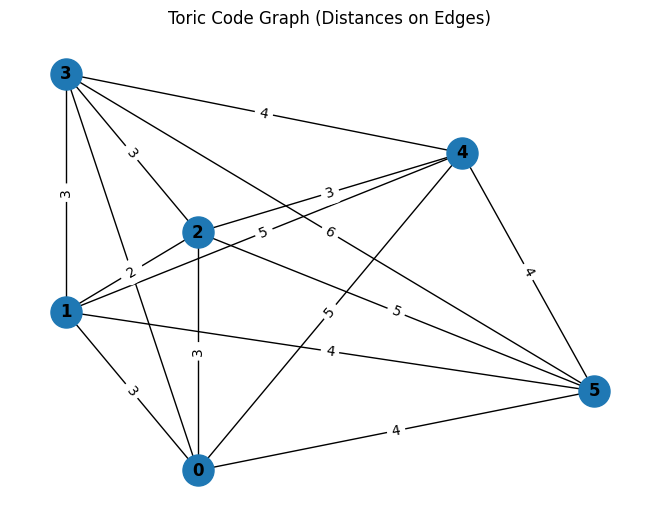

MWPM solution 1: [((4, 5), (5, 2)), ((2, 1), (1, 6)), ((2, 4), (1, 3))]


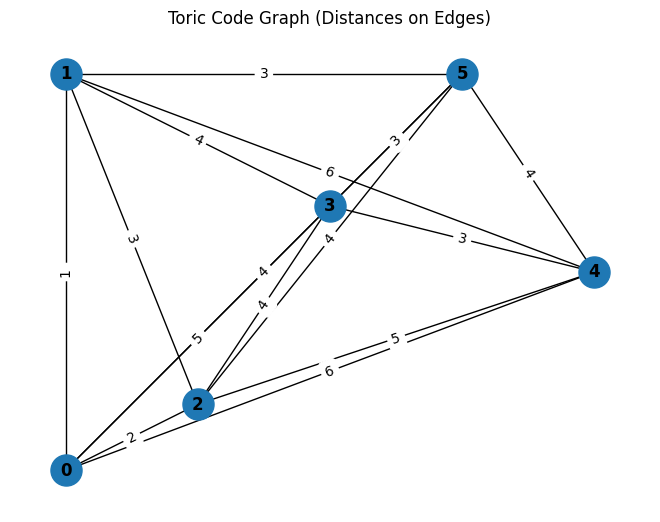

MWPM solution 2: [((1, 0), (2, 1)), ((3, 4), (5, 3)), ((1, 6), (4, 6))]


In [6]:
def toric_distance(u, v, L):

    """
    Function that computes Manhattan distance between two flagged syndromes on toric grid
    
    ----------
    u: list[int]
        x and y corrdinate of first syndrome
    v: list[int]
        x and y corrdinate of second syndrome.
    L: int
        Size of toric surface

    Returns
        list of syndromes pairs obtained by MWPM
    -------
    """

    dx = abs(u[0] - v[0])
    dx = min(dx, L - dx)
    dy = abs(u[1] - v[1])
    dy = min(dy, L - dy)
    return dx + dy

def mwpm_decoder_toric(flagged_stabilizers, L):

    """
    Function that takes a list of syndrome locations and returns MWPM result
    ----------
    u: list[list[int]]
        list of lists containing flagged syndrome locations
    L: int
        Size of toric surface

    Returns
        interger Manhattan distance between two syndrome locations
    -------
    """

    G = nx.Graph()
    # Add each flagged stabilizer as a node
    for i, coord in enumerate(flagged_stabilizers):
        G.add_node(i, pos=coord)

    # Add edges with wrapped Manhattan distance as weight
    for i in range(len(flagged_stabilizers)):
        for j in range(i + 1, len(flagged_stabilizers)):
            dist = toric_distance(flagged_stabilizers[i], flagged_stabilizers[j], L)
            G.add_edge(i, j, weight=dist)

    # Draw the graph
    pos = {node: G.nodes[node]['pos'] for node in G.nodes}
    nx.draw(G, pos, with_labels=True, node_size=500, font_weight='bold')
    # Add edge labels (i.e., distances)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Toric Code Graph (Distances on Edges)")
    plt.show()

    #Performs MWPM
    matching_indices = nx.min_weight_matching(G)

    # Convert node indices back to stabilizer coordinates for clarity
    matching_solution = []
    for i, j in matching_indices:
        matching_solution.append((G.nodes[i]['pos'], G.nodes[j]['pos']))
    return matching_solution

flagged_1 = [(2, 1), (1, 3), (2, 4), (1, 6), (4,5), (5,2)]
flagged_2 = [(1, 0), (1, 6), (2, 1), (3, 4), (5,3), (4,6)]
L = 7

print("MWPM solution 1:",mwpm_decoder_toric(flagged_1, L))
print("MWPM solution 2:", mwpm_decoder_toric(flagged_2, L))

A logical error occurs  in case 1.

<img src="../Images/toric/mwpmsolution1.png"  title="Landscape Image" width="600">


A logical error does not occur in case 2

<img src="../Images/toric/mwpmsolution2.png"  title="Landscape Image" width="600">

## 6.7 The Planar and Surface Codes ##

One of the biggest problems with the toric code is that it is not very practical. Some qubit modalities could utilize the toric code, but many modalities such as superconducting cannot as there is no easy way to map a torus to qubits arranged on a plane.  This requires some modifications to produce the famous surface code that is much more practical and the basis for many experimental QEC demonstrations today. 


The figure below shows the steps to get there. First, the toric code is transformed into the planar code by eliminating the periodic boundary conditions and capping one pair of parallel slides to form a smooth edge. The other edge is called a rough edge. This allows the code to now lie in a plane which is much more suitable for hardware implementation.  

<img src="../Images/toric/rotated.png"  title="Landscape Image" width="1000">

Changing the topology does impact the logical encoding.  Now it is not possible to form loops around the smooth edges (top to bottom) resulting in the loss of a degree of freedom and therefore a logical qubit. 

It is possible to improve on the planar code with a few transformations that allow encoding of a logical qubit with the same distance but using fewer data qubits. If you place a green or purple square on each vertex and plaquette stabilizer, respectively,  and then rotate by 45 degrees, the basis for the so called rotated surface code is formed. 

Special boundary 2-qubit stabilizers are added around the faces of the surface to finish the code layout. Previously all error chains flagged exactly two stabilizers. Now, if an error chain starts on the boundary, it is possible to only flag a single stabilizer.  Thus, this must be taken into account when decoding.

The rotated surface code can now encode a single logical qubit with distance $L$ using $L^2$ fewer qubits. 

## Summary ##

Topological codes are central to both the history of QEC and much of the current research literature.  after completing this lab, you should have a better understanding of what a topological code is, why it is used, and a basic understanding of their inner workings.  In addition, coding the toric code in CUDA-Q provides deeper insight into the challenges of implementing such a code.   